  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021        

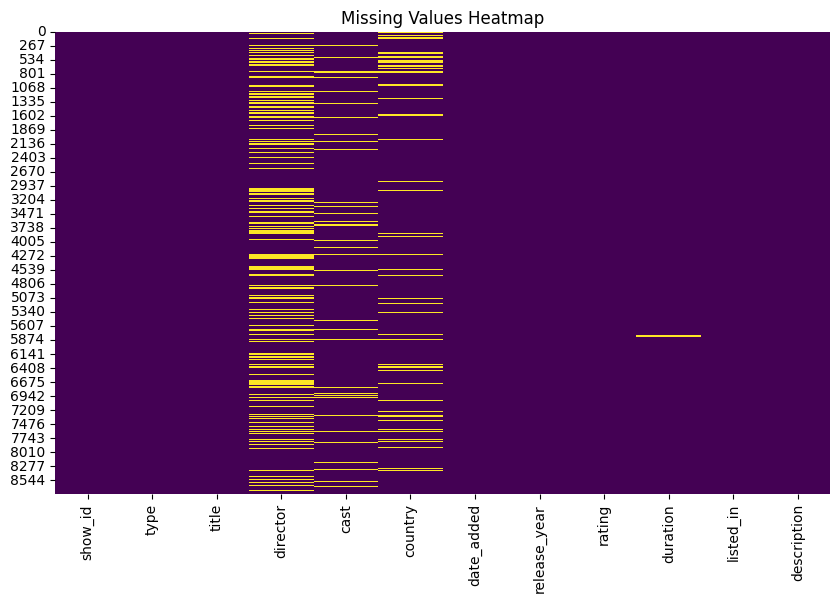

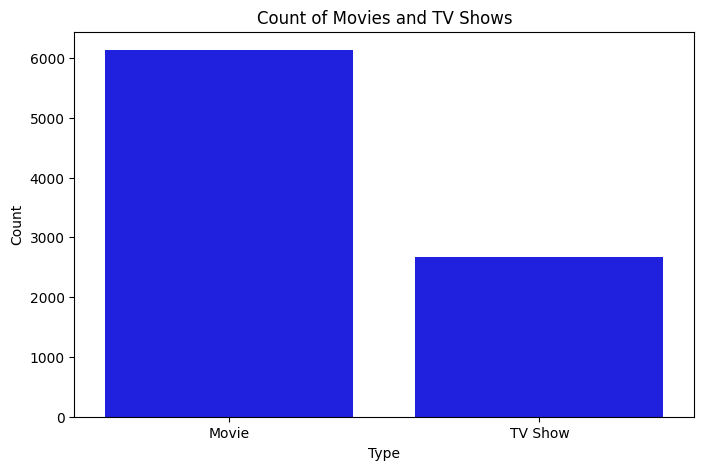

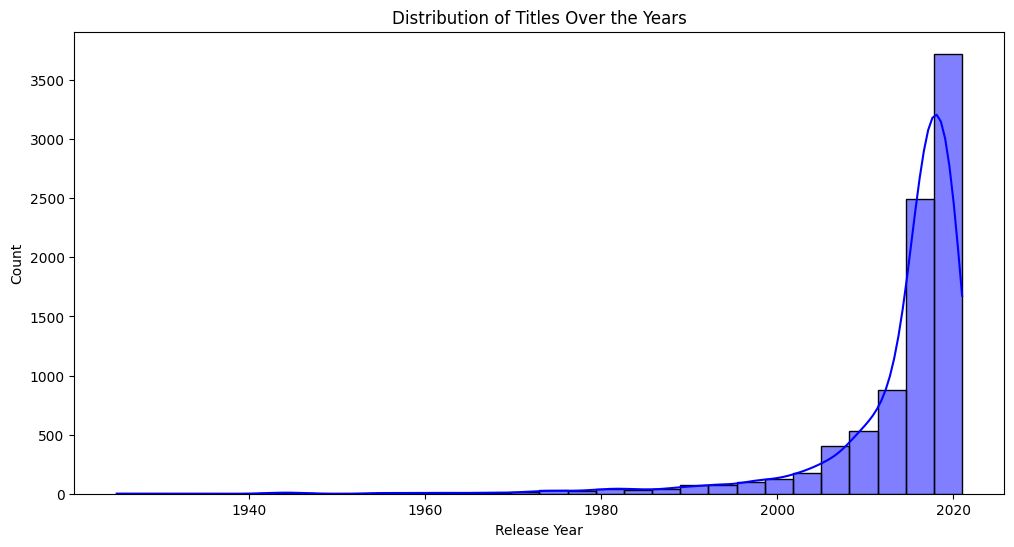

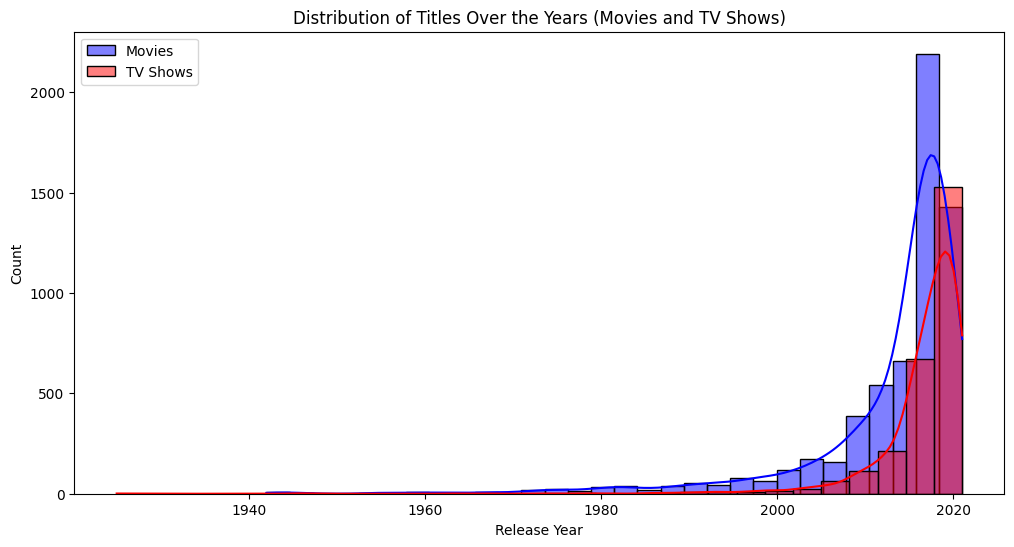

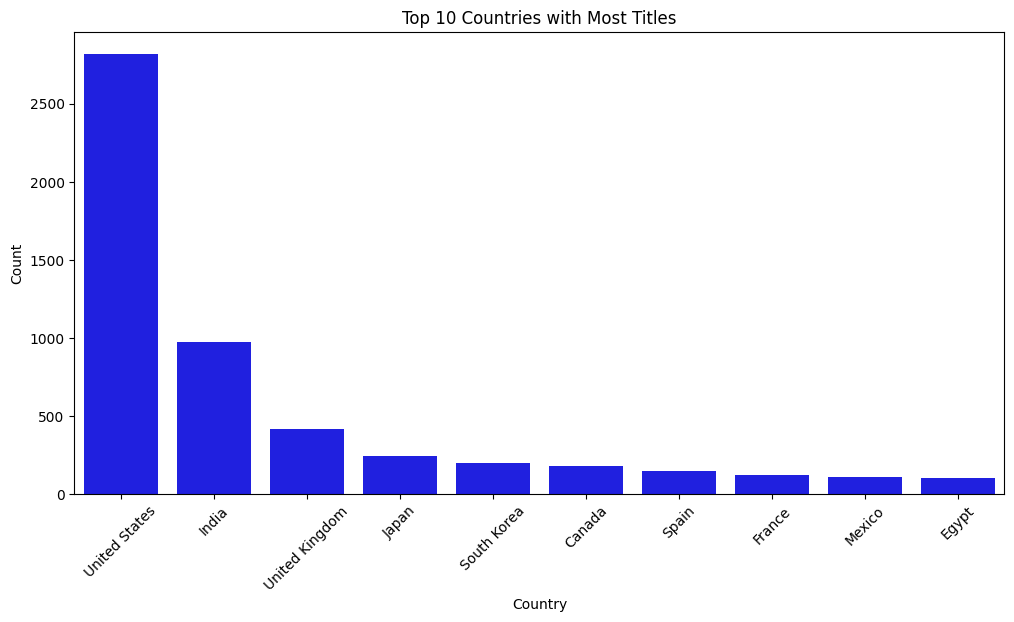

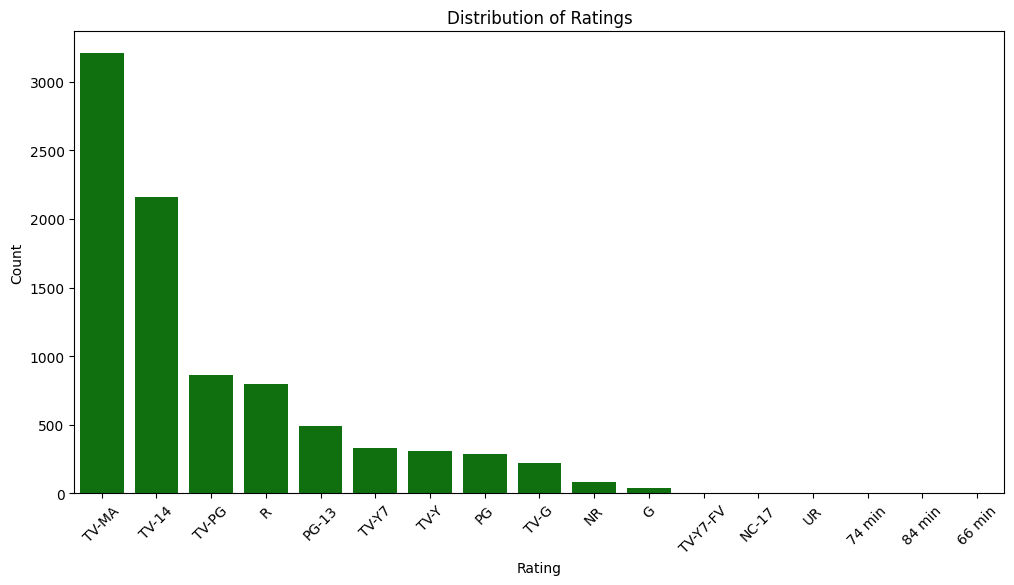

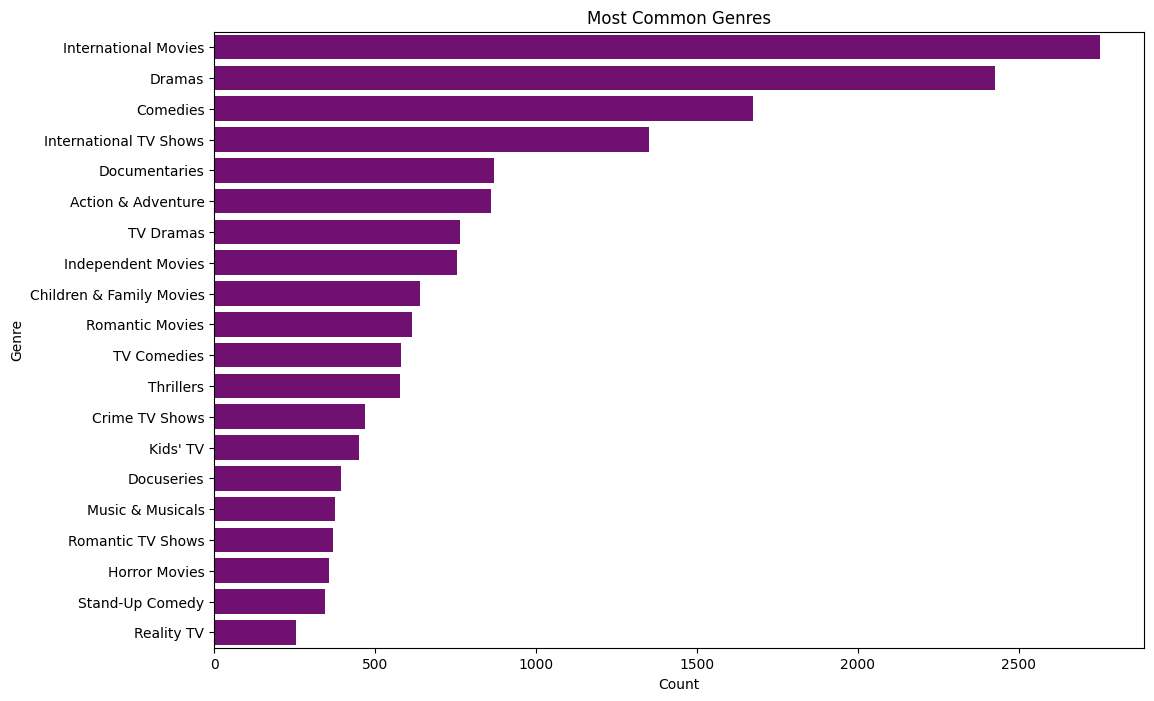

['Movie' 'TV Show']
['TV-MA' 'TV-14' 'PG-13' 'PG' 'R' 'TV-PG' 'G' 'TV-Y7' 'TV-G' 'TV-Y'
 'NC-17' 'NR' 'TV-Y7-FV' 'UR']


In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('netflix_titles.csv')

# Display the first few rows of the dataset
print(df.head())

# Basic information about the dataset
print(df.info())

# Summary statistics of the dataset
print(df.describe(include='all'))

# Checking for missing values
missing_values = df.isnull().sum()
print(missing_values)

# Visualizing missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# Count of Movies and TV Shows
type_counts = df['type'].value_counts()

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='type', color='blue')
plt.title('Count of Movies and TV Shows')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

# Distribution of release years
plt.figure(figsize=(12, 6))
sns.histplot(df['release_year'], bins=30, kde=True, color='blue')
plt.title('Distribution of Titles Over the Years')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.show()

# Distribution of release years for Movies and TV Shows separately
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['type'] == 'Movie'], x='release_year', bins=30, kde=True, color='blue', label='Movies')
sns.histplot(data=df[df['type'] == 'TV Show'], x='release_year', bins=30, kde=True, color='red', label='TV Shows')
plt.title('Distribution of Titles Over the Years (Movies and TV Shows)')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.legend()
plt.show()

# Top 10 countries with the most titles
top_countries = df['country'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.index, y=top_countries.values, color='blue')
plt.title('Top 10 Countries with Most Titles')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Distribution of ratings
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='rating', order=df['rating'].value_counts().index, color='green')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Split the listed_in column and count the occurrences of each genre
genres = df['listed_in'].str.split(', ', expand=True).stack().value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(x=genres.values[:20], y=genres.index[:20], color='purple')
plt.title('Most Common Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()


# Data cleaning - remove rows with missing values
df_cleaned = df.dropna()
df_cleaned = df_cleaned.reset_index()

# Check unique values in columns
print(df_cleaned['type'].unique())
print(df_cleaned['rating'].unique())

# Extract features needed for recommendations
df_features = df_cleaned[['title', 'type', 'rating', 'listed_in']].copy()

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# KNN recommendation function
def knn_recommendation(title, k=5):
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df_features['listed_in'])

    knn = NearestNeighbors(n_neighbors=k+1, metric='cosine')
    knn.fit(tfidf_matrix)

    idx = df_features[df_features['title'].str.contains(title, case=False, regex=False)].index
    if len(idx) == 0:
        print(f"Nie znaleziono tytułu zawierającego '{title}'.")
        return []

    idx = idx[0]
    distances, indices = knn.kneighbors(tfidf_matrix[idx], n_neighbors=k+1)

    recommended_titles = df_features.iloc[indices[0]].title.values[1:]
    return recommended_titles

In [23]:
# Soft set recommendation function
def soft_set_recommendation(title, threshold=0.6):
    # Find the genres of the input title
    input_row = df_features[df_features['title'].str.contains(title, case=False, regex=False)]
    if input_row.empty:
        print(f"Nie znaleziono tytułu zawierającego '{title}'.")
        return []

    input_genres = set([genre.strip().lower() for genre in input_row.iloc[0]['listed_in'].split(',')])
    
    genres_list = df_features['listed_in'].str.split(',').apply(lambda x: set([i.strip().lower() for i in x]))
    
    def calculate_similarity(genres):
        return len(input_genres.intersection(genres)) / len(input_genres.union(genres))
    
    df_features['similarity'] = genres_list.apply(calculate_similarity)
    recommendations = df_features.sort_values(by='similarity', ascending=False).head(6).title.values[1:]
    
    return recommendations

In [24]:
# Feature similarity calculation function
def feature_similarity(title1, title2):
    features1 = df_features[df_features['title'].str.contains(title1, case=False, regex=False)]
    features2 = df_features[df_features['title'] == title2]

    if len(features1) == 0 or len(features2) == 0:
        return 0  # Return 0 if no matching titles are found

    features1 = features1.iloc[0]
    features2 = features2.iloc[0]
    
    similarity = 0
    if features1['type'] == features2['type']:
        similarity += 1
    if features1['rating'] == features2['rating']:
        similarity += 1
    
    genres1 = set(features1['listed_in'].split(', '))
    genres2 = set(features2['listed_in'].split(', '))
    genre_similarity = len(genres1.intersection(genres2)) / len(genres1.union(genres2))
    similarity += genre_similarity
    
    return similarity / 3  # Average similarity (3 features: type, rating, genre)

# Evaluation of recommendations accuracy
def evaluate_recommendations_accuracy(input_titles, recommended_titles):
    total_accuracy = 0
    for input_title in input_titles:
        input_accuracy = 0
        recommended_titles_for_input = recommended_titles.get(input_title, [])
        if len(recommended_titles_for_input) > 0:
            for recommended_title in recommended_titles_for_input:
                input_accuracy += feature_similarity(input_title, recommended_title)
            input_accuracy /= len(recommended_titles_for_input)
            total_accuracy += input_accuracy
    if total_accuracy == 0:
        return 0  # Return 0 if there are no recommendations
    total_accuracy /= len(input_titles)
    return total_accuracy * 100

# Example input titles
input_titles = ["God of War"]
# KNN recommendations
knn_recommended_titles = {}
for input_title in input_titles:
    knn_recommended_titles[input_title] = knn_recommendation(input_title)
    print(f"Rekomendacje dla '{input_title}' (KNN): {knn_recommended_titles[input_title]}")

# Soft set recommendations
soft_set_recommended_titles = {}
for input_title in input_titles:
    soft_set_recommended_titles[input_title] = soft_set_recommendation(input_title)
    print(f"Rekomendacje dla '{input_title}' (Zbiory miękkie): {soft_set_recommended_titles[input_title]}")

# Accuracy evaluation of recommendations
knn_accuracy = evaluate_recommendations_accuracy(input_titles, knn_recommended_titles)
soft_set_accuracy = evaluate_recommendations_accuracy(input_titles, soft_set_recommended_titles)

print(f"Dokładność KNN: {knn_accuracy}%")
print(f"Dokładność zbiorów miękkich: {soft_set_accuracy}%")

Rekomendacje dla 'God of War' (KNN): ['Jailbreak' 'Twins Mission' 'Manhunt' 'The Killer' 'High & Low The Movie']
Rekomendacje dla 'God of War' (Zbiory miękkie): ['Department' 'Dragon Tiger Gate' 'Disciples Of The 36th Chamber'
 'Imperfect' 'S Storm']
Dokładność KNN: 66.66666666666666%
Dokładność zbiorów miękkich: 66.66666666666666%
